In [264]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from gplearn import genetic
from gplearn.functions import make_function
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.fitness import make_fitness
from sklearn.linear_model import LinearRegression

In [121]:
etf_data = pd.read_csv('5500_dataset2.csv')
etf_data['Date'] = etf_data['Year'].astype(str) + '-' + etf_data['Month'].astype(str)
etf_data['Date'] = pd.to_datetime(etf_data['Date'], format='%Y-%m')
etf_data.set_index('Date', inplace=True)
etf_data.drop(['Year', 'Month'], axis=1, inplace=True)
etf_data = etf_data.resample('ME').last()
tickers = ['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']
macro_vars = [col for col in etf_data.columns if col not in tickers]
etf_data_long = etf_data.reset_index().melt(id_vars=['Date'], value_vars=tickers,
                                            var_name='Tickers', value_name='Price')
macro_data = etf_data[macro_vars]
df = etf_data_long.merge(macro_data, left_on='Date', right_index=True)
df.set_index(['Tickers', 'Date'], inplace=True)
df.sort_index(level='Tickers', inplace=True)
df['Return'] = df['Price'].pct_change()
df = df.dropna()

/var/folders/p8/1y76vmp53_xdnnmmh20lzdh80000gn/T/ipykernel_17812/3019725798.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Price'].pct_change()


In [122]:
features = [col for col in df.columns if col not in ['Price', 'Return']]
X = df[features]
Y = df['Return']

for feature in features:
    if df[feature].dtype == 'object':
        df[feature] = df[feature].str.replace(',', '').astype(float)
        
# Prepare the output dataframe to store rolling exposures
rolling_exposure = pd.DataFrame(index=df.index, columns=features)

# Rolling window length (36 months)
window_length = 36

# Iterate through each ticker group to calculate rolling exposures
for ticker, group in df.groupby(level='Tickers'):
    for end_idx in range(window_length, len(group)):
        window_data = group.iloc[end_idx - window_length:end_idx]
        
        X_window = window_data[features]
        Y_window = window_data['Return']
        
        if len(X_window) == window_length:
            # Fit linear regression model
            model = LinearRegression().fit(X_window, Y_window)
            # Store the coefficients as rolling exposures
            rolling_exposure.loc[window_data.index[-1], features] = model.coef_

# Drop NaN values
rolling_exposure.dropna(inplace=True)


In [175]:
Rank_IC = rolling_exposure['Unemp_Rate'].unstack('Tickers').corrwith(df.unstack('Tickers')['Return'], axis =1,  method='spearman').dropna(how='all')

In [215]:
returns = df.unstack('Tickers')['Return']
exposures = rolling_exposure.unstack('Tickers')
date_list = exposures.index

In [187]:
exposures['CPI'].corrwith(returns, axis=1, method='spearman').dropna(how='all')

Date
2007-11-30   -0.450000
2007-12-31   -0.183333
2008-01-31    0.516667
2008-02-29    0.650000
2008-03-31    0.466667
                ...   
2024-04-30    0.309091
2024-05-31    0.536364
2024-06-30   -0.054545
2024-07-31   -0.063636
2007-10-31   -0.571429
Length: 202, dtype: float64

In [204]:
def exposure_return_IC(exposures, returns, index_item, name=''):
    result = exposures.corrwith(returns, axis=1, method='spearman').dropna(how='all')
    t_stat, _ = stats.ttest_1samp(result, 0)
    
    report = {'name': name,
    'IC mean':round(result.mean(),4),
    'IC std':round(result.std(),4),
    'IR':round(result.mean()/result.std(),4),
    'IC>0':round(len(result[result>0].dropna())/len(result),4),
    'ABS_IC>2%':round(len(result[abs(result) > 0.02].dropna())/len(result),4),
    't_stat':round(t_stat,4),
    }

    report = pd.DataFrame([report])
    
    return result,report
                                                                        
                                                                           

In [227]:
ic_summary = pd.DataFrame()
ic_df=pd.DataFrame(index=date_list)
for feature in features:
    ic, ic_summary_temp = exposure_return_IC(exposures[feature],returns, feature,feature)
    ic_df = pd.concat([ic_df, ic.to_frame(feature)], axis=1)
    ic_summary = pd.concat([ic_summary,ic_summary_temp.set_index('name')],axis = 0)
ic_df = ic_df.sort_index()

In [228]:
ic_summary

,IC mean,IC std,IR,IC>0,ABS_IC>2%,t_stat
name,,,,,,
BusinessApplications,-0.0417,0.3872,-0.1078,0.4406,0.9505,-1.5322
ConstructionSpending,0.0080,0.4060,0.0198,0.4901,0.9851,0.2815
DurableGoodsNewOrders,-0.0150,0.4411,-0.0340,0.4653,0.9752,-0.4831
InternationalTrade_Exports,0.0534,0.4180,0.1278,0.5248,0.9554,1.8168
InternationalTrade_Imports,-0.0049,0.4220,-0.0117,0.4851,0.9851,-0.1663
...,...,...,...,...,...,...
Unemp_Rate,0.0114,0.4189,0.0272,0.4950,0.9554,0.3870
Auto Sales,0.0012,0.4147,0.0029,0.5248,0.9802,0.0417
Durable Goods,0.0091,0.4319,0.0210,0.5099,0.9752,0.2991


In [251]:
ic_summary[ic_summary['IR']>0.15]

,IC mean,IC std,IR,IC>0,ABS_IC>2%,t_stat
name,,,,,,
SalesForManufacturersComputerAndEletronicProductsInventories,0.0878,0.4185,0.2097,0.5842,0.9554,2.9804
MonthlyImportsAllCommodities,0.0699,0.4367,0.1601,0.5545,0.9752,2.2756
ImportAirFreight,0.0754,0.4102,0.1838,0.5396,0.9752,2.6125
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n,0.1194,0.4142,0.2882,0.6089,0.9554,4.0965
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n,0.0973,0.4132,0.2355,0.5792,0.9752,3.3477
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n,0.0894,0.4152,0.2154,0.5693,0.9703,3.0608
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n,0.0940,0.4018,0.2339,0.6089,0.9802,3.3250
PPIIndustryDataTotalManufacturingIndustries\n,0.0683,0.4300,0.1589,0.5644,0.9802,2.2590
PPICommodityDataForAllCommodities,0.0946,0.3952,0.2393,0.5792,0.9653,3.4015


In [244]:
selected_features = ic_summary[ic_summary['IR']>0.15].index

In [249]:
def cumic(name, ic_df):
    ic_df[name].cumsum().plot(figsize=(10,6))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')


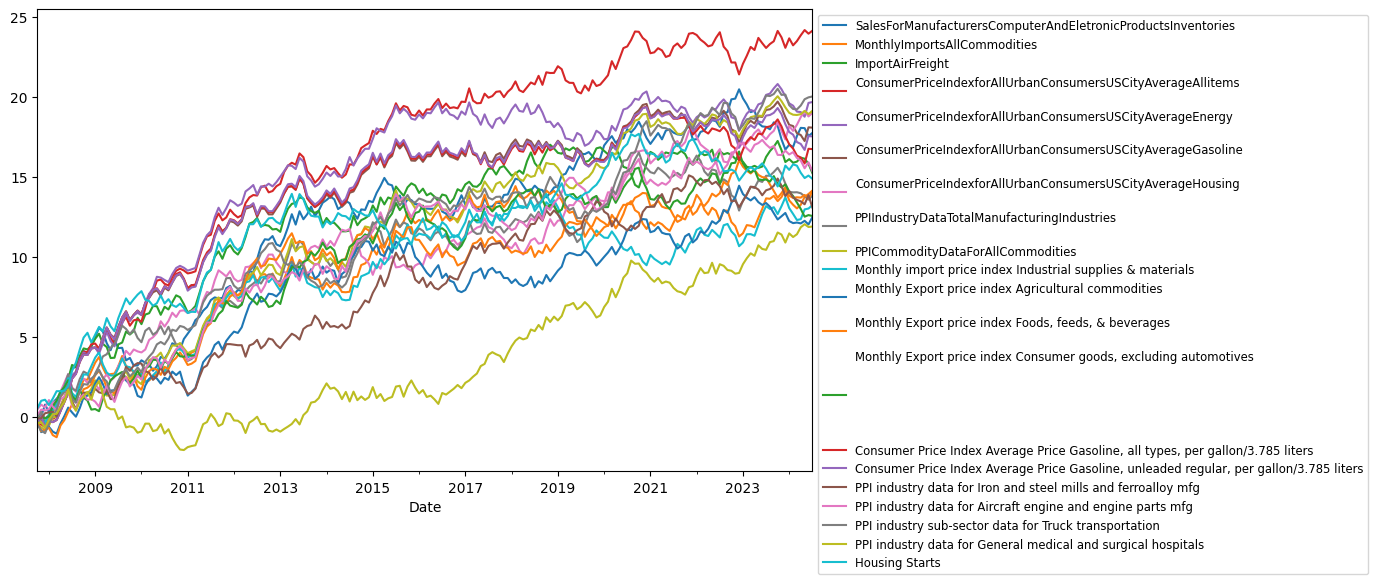

In [250]:
cumic(selected_features, ic_df)

In [254]:
ic_df[selected_features].corr()

,SalesForManufacturersComputerAndEletronicProductsInventories,MonthlyImportsAllCommodities,ImportAirFreight,ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n,ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n,ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n,ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n,PPIIndustryDataTotalManufacturingIndustries\n,PPICommodityDataForAllCommodities,Monthly import price index Industrial supplies & materials,Monthly Export price index Agricultural commodities\n,"Monthly Export price index Foods, feeds, & beverages\n","Monthly Export price index Consumer goods, excluding automotives\n\n\n\n\n","Consumer Price Index Average Price Gasoline, all types, per gallon/3.785 liters","Consumer Price Index Average Price Gasoline, unleaded regular, per gallon/3.785 liters",PPI industry data for Iron and steel mills and ferroalloy mfg,PPI industry data for Aircraft engine and engine parts mfg,PPI industry sub-sector data for Truck transportation,PPI industry data for General medical and surgical hospitals,Housing Starts
SalesForManufacturersComputerAndEletronicProductsInventories,1.000000,0.097886,0.026192,0.057541,0.045942,0.010867,0.044699,0.052364,0.120911,0.075840,0.202538,0.208984,0.130004,0.011088,0.014811,-0.220186,-0.007451,0.094233,0.106576,0.048978
MonthlyImportsAllCommodities,0.097886,1.000000,0.258256,0.443449,0.411839,0.470374,-0.010264,0.626540,0.564242,0.949922,0.167662,0.158385,0.248576,0.480383,0.471610,0.216227,0.283322,0.517852,0.231815,0.317871
ImportAirFreight,0.026192,0.258256,1.000000,0.216392,0.225640,0.316492,-0.094818,0.167106,0.206168,0.316168,0.159401,0.192641,0.079060,0.312472,0.315173,0.243103,0.111221,0.284202,0.198181,0.173479
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n,0.057541,0.443449,0.216392,1.000000,0.674080,0.714795,0.282849,0.585394,0.526534,0.383830,0.175875,0.244860,0.167529,0.724173,0.718720,0.207936,0.302990,0.435093,0.151205,0.319660
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n,0.045942,0.411839,0.225640,0.674080,1.000000,0.890721,0.125425,0.458030,0.543240,0.369223,0.162781,0.236914,0.245125,0.874097,0.886002,0.093995,0.229657,0.443386,-0.098362,0.174403
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n,0.010867,0.470374,0.316492,0.714795,0.890721,1.000000,0.012432,0.521452,0.497734,0.428425,0.195045,0.271198,0.252045,0.989019,0.992962,0.110789,0.306316,0.457945,-0.005566,0.238033
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n,0.044699,-0.010264,-0.094818,0.282849,0.125425,0.012432,1.000000,0.120935,0.268875,-0.057329,0.093190,0.065172,0.093999,0.022875,0.014568,0.084247,0.219762,0.042587,-0.034539,0.075068
PPIIndustryDataTotalManufacturingIndustries\n,0.052364,0.626540,0.167106,0.585394,0.458030,0.521452,0.120935,1.000000,0.737572,0.557254,0.283083,0.256842,0.370480,0.540981,0.531006,0.344890,0.324175,0.555743,0.314582,0.365594
PPICommodityDataForAllCommodities,0.120911,0.564242,0.206168,0.526534,0.543240,0.497734,0.268875,0.737572,1.000000,0.512655,0.494492,0.484049,0.370099,0.506020,0.500806,0.387574,0.322915,0.603552,0.215397,0.192139
Monthly import price index Industrial supplies & materials,0.075840,0.949922,0.316168,0.383830,0.369223,0.428425,-0.057329,0.557254,0.512655,1.000000,0.157655,0.157035,0.207458,0.435345,0.427974,0.228453,0.244547,0.478045,0.205909,0.291926


In [255]:
def hot_corr(name,ic_df):

    ax = plt.subplots(figsize=(len(name), len(name)))
    ax = sns.heatmap(ic_df[name].corr(),vmin=0.4, square=True, annot= True,cmap = 'Blues')
    plt.title('Factors_IC_CORRELATION')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

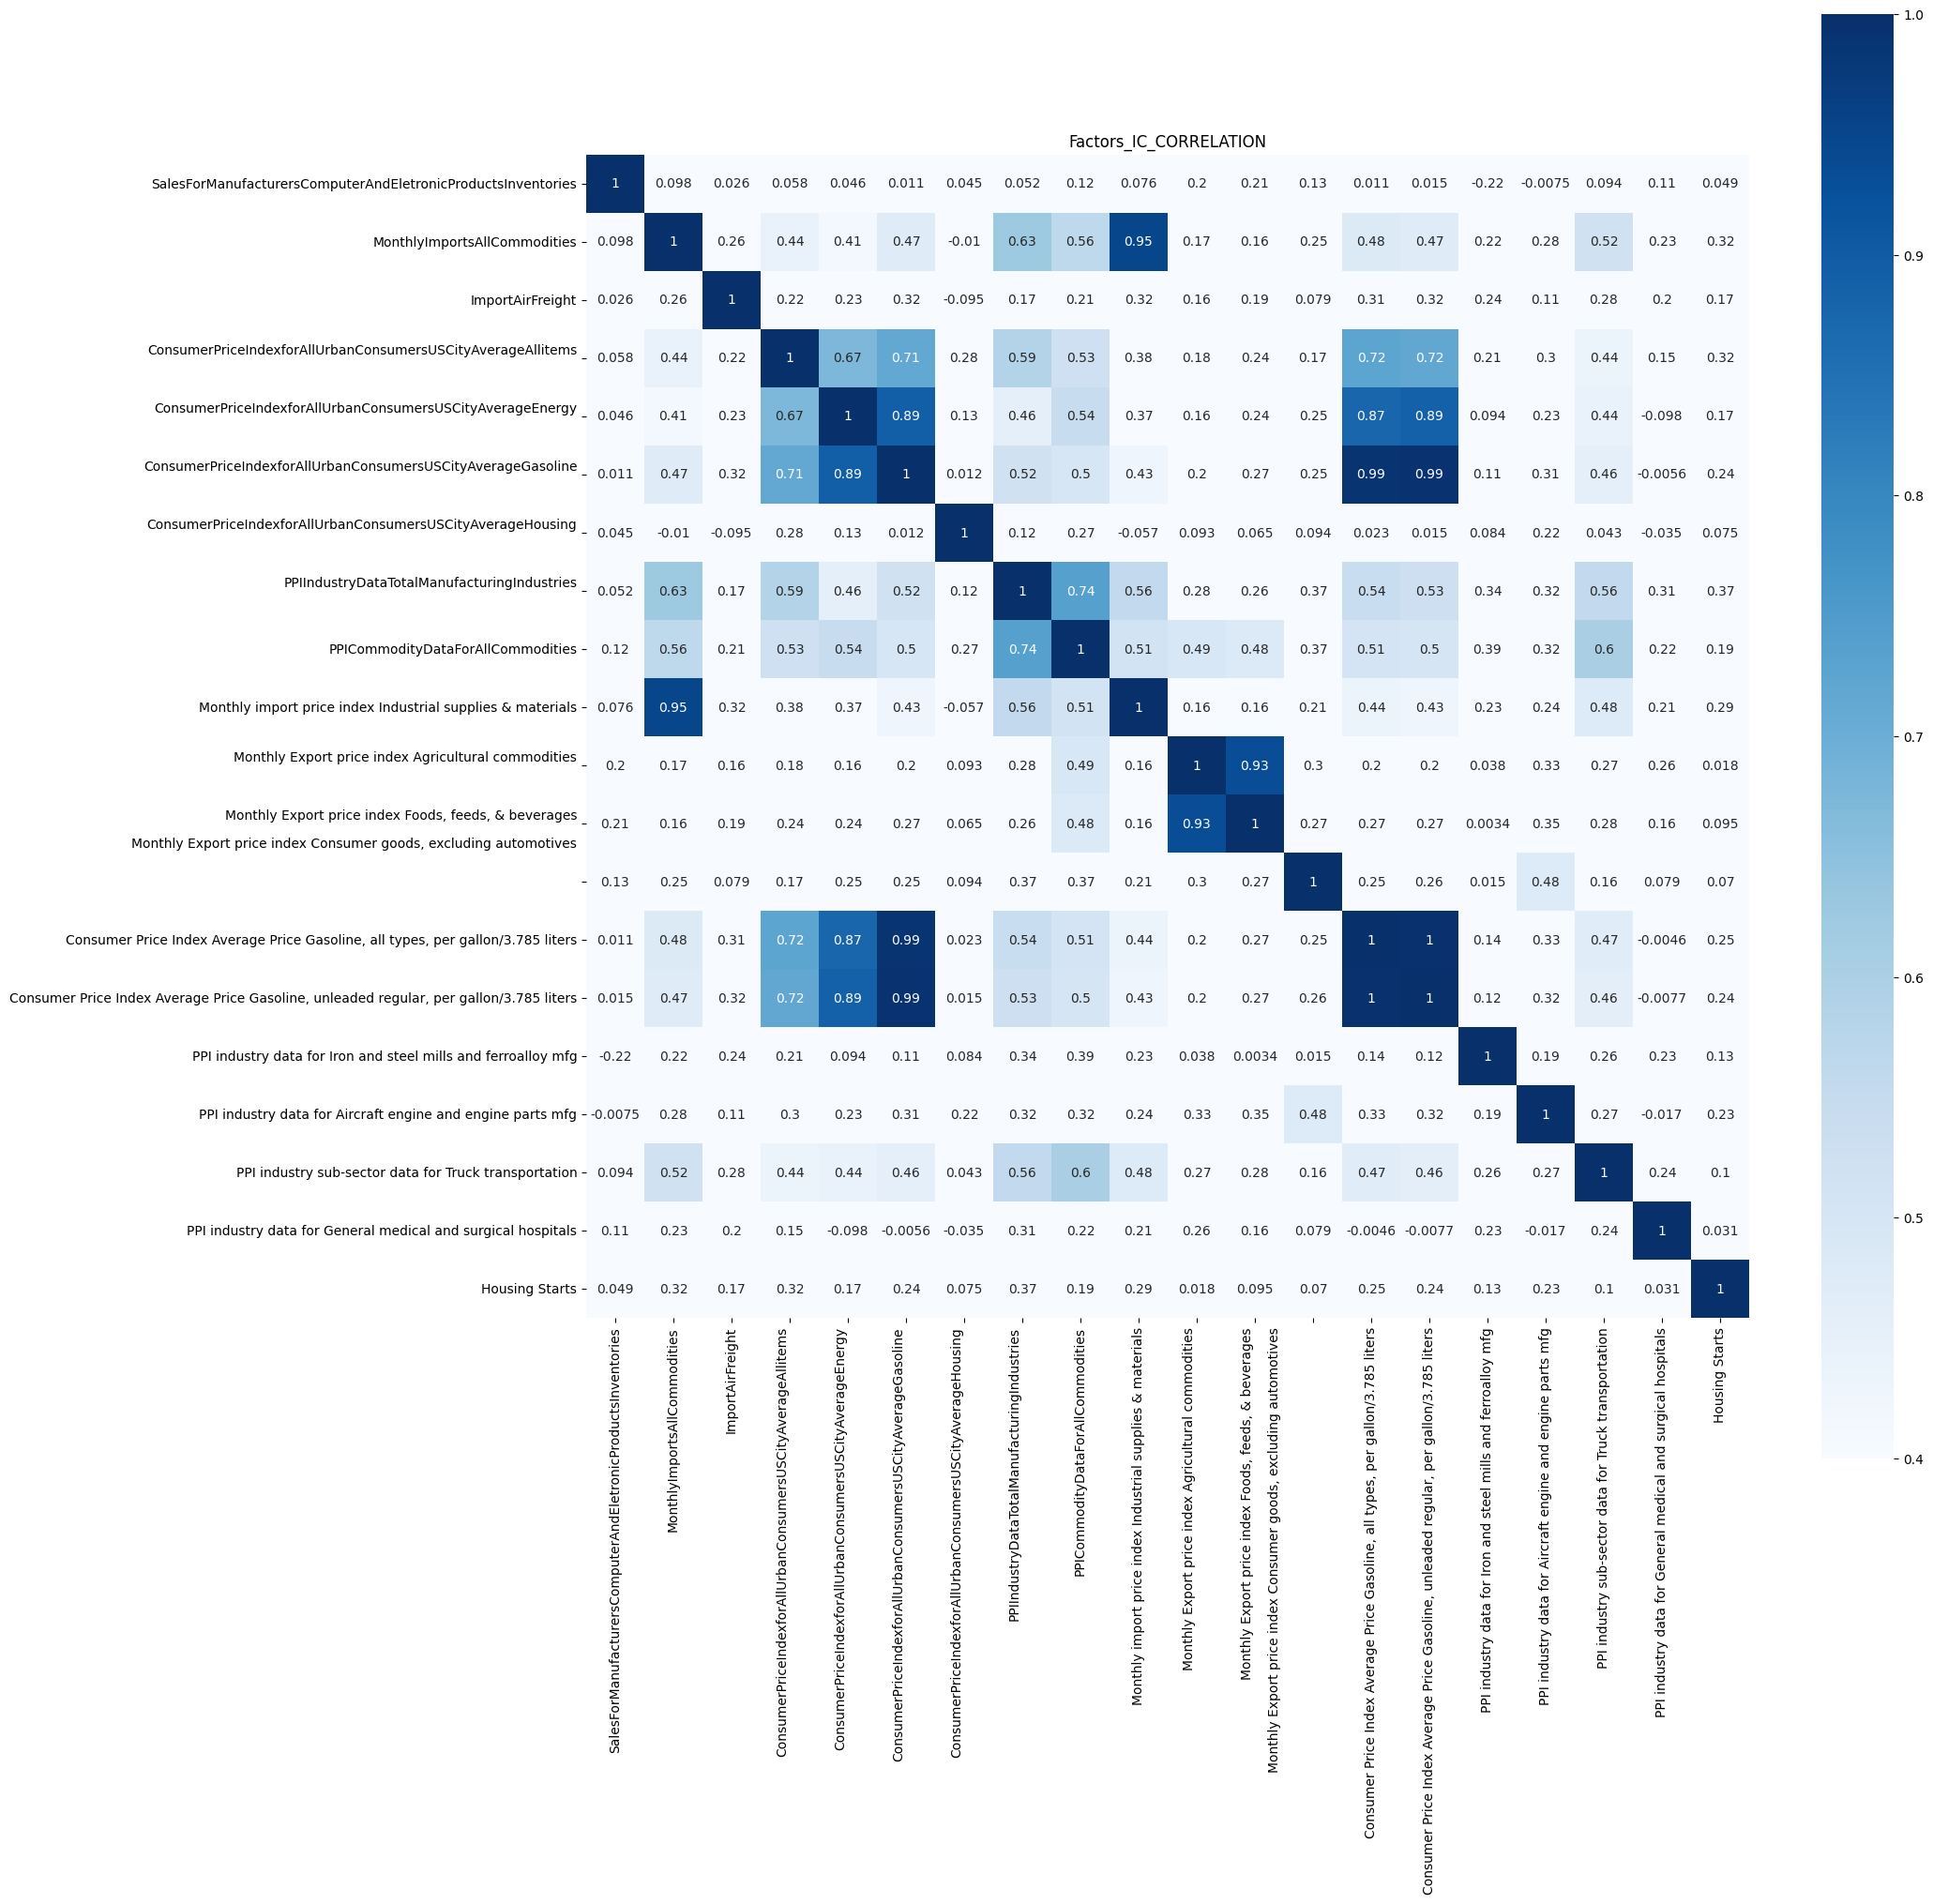

In [256]:
hot_corr(selected_features, ic_df)

In [263]:
# VIF
ic_df_pass = ic_df[selected_features]
VIF = {}
for i in ic_df_pass.columns.tolist():
    y = ic_df_pass[i]
    x = ic_df_pass.drop(i,axis = 1)
    VIF[i] = 1 / (1 - sm.OLS(y.astype(float),x.astype(float),hasconst=False, missing='drop').fit().rsquared)

VIF = pd.DataFrame([VIF]).T
VIF.columns = ['VIF']
VIF.sort_values(by = 'VIF',ascending=False)

,VIF
"Consumer Price Index Average Price Gasoline, unleaded regular, per gallon/3.785 liters",216.242679
"Consumer Price Index Average Price Gasoline, all types, per gallon/3.785 liters",141.289477
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n,83.181083
MonthlyImportsAllCommodities,13.856368
Monthly import price index Industrial supplies & materials,11.968162
"Monthly Export price index Foods, feeds, & beverages\n",11.255252
Monthly Export price index Agricultural commodities\n,11.165734
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n,7.386083
PPICommodityDataForAllCommodities,5.001423
PPIIndustryDataTotalManufacturingIndustries\n,3.857752


In [265]:
def corr_line(ic_df,low = 0.8,high = 1):

    factor_corr = pd.DataFrame(ic_df.dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()

    return factor_corr

In [266]:
high_data = corr_line(ic_df[selected_features])
high_data

CORRELATION
factor_a                                           factor_b                                                       
MonthlyImportsAllCommodities                       Monthly import price index Industrial supplies ...     0.949922
ConsumerPriceIndexforAllUrbanConsumersUSCityAve... ConsumerPriceIndexforAllUrbanConsumersUSCityAve...     0.890721
                                                   Consumer Price Index Average Price Gasoline, al...     0.874097
                                                   Consumer Price Index Average Price Gasoline, un...     0.886002
ConsumerPriceIndexforAllUrbanConsumersUSCityAve... Consumer Price Index Average Price Gasoline, al...     0.989019
                                                   Consumer Price Index Average Price Gasoline, un...     0.992962
Monthly Export price index Agricultural commodi... Monthly Export price index Foods, feeds, & beve...     0.933949
Consumer Price Index Average Price Gasoline, al... Consumer Price Index Average Price Gasoline, un...     0.995801

In [267]:
orth_wait = list(set(high_data.index.get_level_values(0)) | set(high_data.index.get_level_values(1)))
orth_wait

['ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n',
 'Consumer Price Index Average Price Gasoline, unleaded regular, per gallon/3.785 liters',
 'MonthlyImportsAllCommodities',
 'Monthly Export price index Foods, feeds, & beverages\n',
 'Monthly Export price index Agricultural commodities\n',
 'Consumer Price Index Average Price Gasoline, all types, per gallon/3.785 liters',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n',
 'Monthly import price index Industrial supplies & materials']

In [282]:
corr_group = {0:['MonthlyImportsAllCommodities','Monthly import price index Industrial supplies & materials'],
              1:['Monthly Export price index Agricultural commodities\n','Monthly Export price index Foods, feeds, & beverages\n'],
              2:['Consumer Price Index Average Price Gasoline, all types, per gallon/3.785 liters','Consumer Price Index Average Price Gasoline, unleaded regular, per gallon/3.785 liters'],
              3:['ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n','ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n','Consumer Price Index Average Price Gasoline, all types, per gallon/3.785 liters','Consumer Price Index Average Price Gasoline, unleaded regular, per gallon/3.785 liters']}

In [283]:
for i in list(corr_group.keys()):
    del_factors = ic_summary.loc[corr_group[i],'IR'].sort_values(ascending = False).index.tolist()[1:]
    selected_features = [feature for feature in selected_features if feature not in del_factors]
selected_features

['SalesForManufacturersComputerAndEletronicProductsInventories',
 'MonthlyImportsAllCommodities',
 'ImportAirFreight',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n',
 'PPIIndustryDataTotalManufacturingIndustries\n',
 'PPICommodityDataForAllCommodities',
 'Monthly Export price index Foods, feeds, & beverages\n',
 'Monthly Export price index Consumer goods, excluding automotives\n\n\n\n\n',
 'PPI industry data for Iron and steel mills and ferroalloy mfg',
 'PPI industry data for Aircraft engine and engine parts mfg',
 'PPI industry sub-sector data for Truck transportation',
 'PPI industry data for General medical and surgical hospitals',
 'Housing Starts']

In [284]:
def corr_line(ic_df,low = 0.65,high = 1):
    
    factor_corr = pd.DataFrame(ic_df.dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()

    return factor_corr

In [285]:
middle_data = corr_line(ic_df[selected_features])
middle_data

,,CORRELATION
factor_a,factor_b,
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n,ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n,0.674080
PPIIndustryDataTotalManufacturingIndustries\n,PPICommodityDataForAllCommodities,0.737572


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'PPIIndustryDataTotalManufacturingIndustries\n'),
  Text(0, 1.5, 'PPICommodityDataForAllCommodities'),
  Text(0, 2.5, 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n'),
  Text(0, 3.5, 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n')])

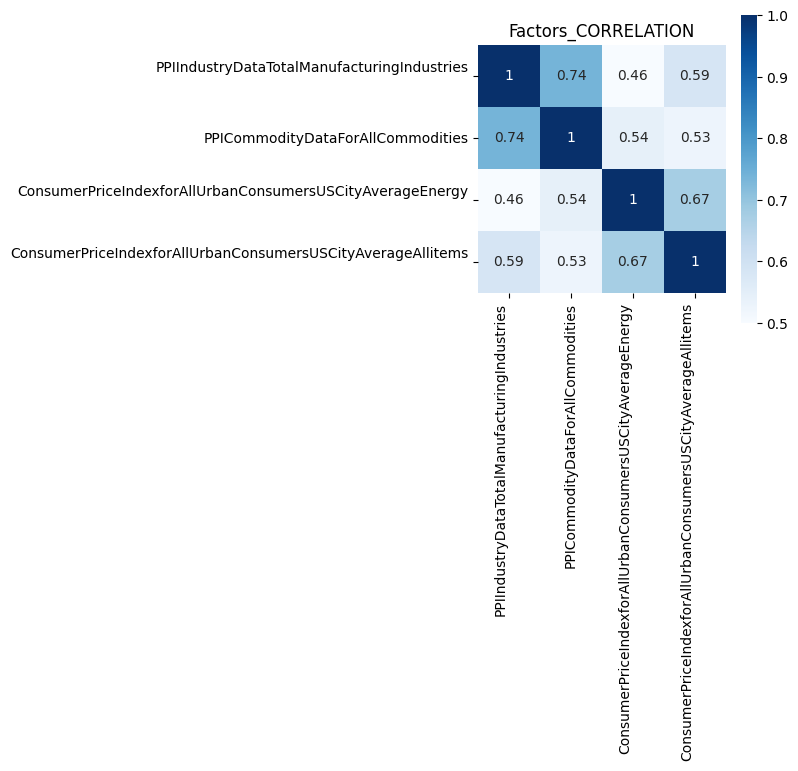

In [287]:
orth_wait = list(set(middle_data.index.get_level_values(0)) | set(middle_data.index.get_level_values(1)))
ax = plt.subplots(figsize=(len(orth_wait), len(orth_wait)))
ax = sns.heatmap(ic_df[orth_wait].corr(),vmin=0.5, square=True, annot= True,cmap = 'Blues')
plt.title('Factors_CORRELATION')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [303]:
selected_features

['SalesForManufacturersComputerAndEletronicProductsInventories',
 'MonthlyImportsAllCommodities',
 'ImportAirFreight',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n',
 'PPIIndustryDataTotalManufacturingIndustries\n',
 'PPICommodityDataForAllCommodities',
 'Monthly Export price index Foods, feeds, & beverages\n',
 'Monthly Export price index Consumer goods, excluding automotives\n\n\n\n\n',
 'PPI industry data for Iron and steel mills and ferroalloy mfg',
 'PPI industry data for Aircraft engine and engine parts mfg',
 'PPI industry sub-sector data for Truck transportation',
 'PPI industry data for General medical and surgical hospitals',
 'Housing Starts']

In [314]:
base_function = ['add', 'sub', 'mul', 'div','abs','neg']

window = 10

def _delta(data):
    value = np.diff(data.flatten())
    value = np.append(0, value)

    return value

def _sma(data):
    window=36
    value = np.array(pd.Series(data.flatten()).rolling(window).mean().tolist())
    value = np.nan_to_num(value)
    
    return value

def _stddev(data):
    window=36
    value = np.array(pd.Series(data.flatten()).rolling(window).std().tolist())
    value = np.nan_to_num(value)
    return value

stddev = make_function(function=_stddev, name='stddev', arity=1)
delta = make_function(function=_delta, name='delta', arity=1)
sma = make_function(function=_sma, name='sma', arity=1)

user_function = [stddev,delta,sma]

function_set = base_function + user_function

In [317]:
gp_factor_train = rolling_exposure[selected_features]
base_Factor = gp_factor_train.columns.tolist()
gp_factor_train.head()

SalesForManufacturersComputerAndEletronicProductsInventories  \
Tickers Date                                                                      
XLB     2007-11-30                                           0.000126             
        2007-12-31                                            0.00023             
        2008-01-31                                           0.000162             
        2008-02-29                                           0.000164             
        2008-03-31                                           0.000119             

                   MonthlyImportsAllCommodities ImportAirFreight  \
Tickers Date                                                       
XLB     2007-11-30                    -0.000007         0.000001   
        2007-12-31                    -0.000006         0.000001   
        2008-01-31                    -0.000004        -0.000004   
        2008-02-29                    -0.000004        -0.000004   
        2008-03-31                    -0.000001        -0.000002   

                   ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n  \
Tickers Date                                                                       
XLB     2007-11-30                                          -0.000001              
        2007-12-31                                           0.000001              
        2008-01-31                                          -0.000002              
        2008-02-29                                          -0.000002              
        2008-03-31                                               -0.0              

                   ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n  \
Tickers Date                                                                     
XLB     2007-11-30                                          -0.000025            
        2007-12-31                                          -0.000008            
        2008-01-31                                          -0.000025            
        2008-02-29                                          -0.000025            
        2008-03-31                                          -0.000005            

                   ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n  \
Tickers Date                                                                      
XLB     2007-11-30                                          -0.000003             
        2007-12-31                                          -0.000002             
        2008-01-31                                          -0.000002             
        2008-02-29                                          -0.000002             
        2008-03-31                                          -0.000001             

                   PPIIndustryDataTotalManufacturingIndustries\n  \
Tickers Date                                                       
XLB     2007-11-30                                     -0.000004   
        2007-12-31                                     -0.000002   
        2008-01-31                                     -0.000004   
        2008-02-29                                     -0.000004   
        2008-03-31                                           0.0   

                   PPICommodityDataForAllCommodities  \
Tickers Date                                           
XLB     2007-11-30                         -0.000001   
        2007-12-31                          0.000004   
        2008-01-31                         -0.000004   
        2008-02-29                         -0.000004   
        2008-03-31                          0.000001   

                   Monthly Export price index Foods, feeds, & beverages\n  \
Tickers Date                                                                
XLB     2007-11-30                                           0.000018       
        2007-12-31                                           0.000024       
        2008-01-31                  

In [318]:
stock_list = gp_data_train.index.get_level_values(0).tolist()

del_index = []
for i in range(1,len(stock_list)):
    if stock_list[i - 1] != stock_list[i]:
        del_index.append(i)

In [319]:
def _my_metric_group(y, y_pred, w):
    x1 = pd.Series(y.flatten())
    for i in del_index:
        try:
            y_pred[i:i+window*5] = np.nan           
        except:
            break
    
    x2 = pd.Series(y_pred.flatten())
  
    df = pd.concat([x1.to_frame('y'),
                    x2.to_frame('y_pred')],axis=1).dropna()

   
    df.sort_values(by = 'y_pred',ascending = True,inplace = True)
    
    gap = [int(i) for i in list(np.linspace(start = 0, stop = len(df), num = 11))]
    y_1 = df["y"][0:gap[1]].mean()
    y_2 = df["y"][gap[1]:gap[2]].mean()
    y_3 = df["y"][gap[2]:gap[3]].mean()
    y_4 = df["y"][gap[3]:gap[4]].mean()
    y_5 = df["y"][gap[4]:gap[5]].mean()
    y_6 = df["y"][gap[5]:gap[6]].mean()
    y_7 = df["y"][gap[6]:gap[7]].mean()
    y_8 = df["y"][gap[7]:gap[8]].mean()
    y_9 = df["y"][gap[8]:gap[9]].mean()
    y_10 = df["y"][gap[9]:].mean()
   
    value = (np.corrcoef(np.array([y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10]).argsort(),
                         (np.arange(1,11)))[0,1])
    
    return value

my_metric_group = make_fitness(function=_my_metric_group, greater_is_better=True)

In [327]:
gp_factor_train[base_Factor].index

MultiIndex([('XLB', '2007-11-30'),
            ('XLB', '2007-12-31'),
            ('XLB', '2008-01-31'),
            ('XLB', '2008-02-29'),
            ('XLB', '2008-03-31'),
            ('XLB', '2008-04-30'),
            ('XLB', '2008-05-31'),
            ('XLB', '2008-06-30'),
            ('XLB', '2008-07-31'),
            ('XLB', '2008-08-31'),
            ...
            ('XLY', '2023-10-31'),
            ('XLY', '2023-11-30'),
            ('XLY', '2023-12-31'),
            ('XLY', '2024-01-31'),
            ('XLY', '2024-02-29'),
            ('XLY', '2024-03-31'),
            ('XLY', '2024-04-30'),
            ('XLY', '2024-05-31'),
            ('XLY', '2024-06-30'),
            ('XLY', '2024-07-31')],
           names=['Tickers', 'Date'], length=1927)

In [330]:
X_train = np.nan_to_num(gp_factor_train[base_Factor].values)
y_train = np.nan_to_num(df.loc[gp_factor_train[base_Factor].index]['Return'])

metric_type = 'my_metric_group'
version = 'v3'

generations = 3
population_size = 10000
random_state = 0

est_gp = SymbolicTransformer(feature_names = base_Factor,                     
                            function_set = function_set,                     
                            stopping_criteria = 0.03,                         
                            metric = my_metric_group,                         
                            generations = generations,                        
                            population_size = population_size,                
                            tournament_size = 50,                             
                            init_depth = (2,2),                               
                            random_state = random_state,                      
                            n_components = 20,                                
                            const_range = (-1,1),                             
                            n_jobs = -1                                    
                         )


est_gp.fit(X_train, y_train)

best_programs = est_gp._best_programs
best_programs_dict = {}

for p in best_programs:
    factor_name = 'Macro_Factors' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}

best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict[best_programs_dict.fitness.abs() >= 0.2]
best_programs_dict = best_programs_dict.sort_values(by= 'fitness',ascending=False)
best_programs_dict

,fitness,expression,depth,length
Macro_Factors1,0.980879,mul(div(ConsumerPriceIndexforAllUrbanConsumers...,2,7
Macro_Factors2,0.971758,delta(add(ConsumerPriceIndexforAllUrbanConsume...,2,4
Macro_Factors3,0.960636,delta(delta(ConsumerPriceIndexforAllUrbanConsu...,2,3
Macro_Factors4,0.957636,add(neg(PPI industry data for Iron and steel m...,2,6
Macro_Factors5,0.924273,delta(sma(ConsumerPriceIndexforAllUrbanConsume...,2,3
Macro_Factors6,0.912152,sub(PPIIndustryDataTotalManufacturingIndustrie...,1,3
Macro_Factors7,0.911152,delta(add(PPI industry data for Iron and steel...,2,4
Macro_Factors10,0.89903,"neg(mul(MonthlyImportsAllCommodities, PPI indu...",2,4
Macro_Factors9,0.89803,"add(delta(MonthlyImportsAllCommodities), delta...",2,5
Macro_Factors11,0.89703,sub(add(ConsumerPriceIndexforAllUrbanConsumers...,2,6


In [331]:
import graphviz
def alpha_factor_graph(num):

    factor = best_programs[num-1]
    print(factor)
    print('fitness: {0}, depth: {1}, length: {2}'.format(factor.fitness_, factor.depth_, factor.length_))

    dot_data = factor.export_graphviz()
    graph = graphviz.Source(dot_data)
    graph.render('images/alpha_factor_graph', format='png', cleanup=True)
    
    return graph

delta(sma(ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems
))
fitness: 0.9242727272727272, depth: 2, length: 3


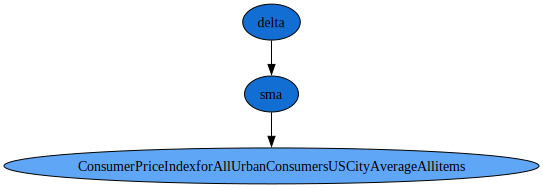

In [337]:
alpha_factor_graph(5)

In [376]:
def macro_factor_5(df):
    value1 = df['ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n'].rolling(36).mean()
    value = value1.pct_change()
    
    return value.unstack('Tickers')

In [379]:
macro_5 = macro_factor_5(rolling_exposure)

In [373]:
def exposure_return_IC(exposures, returns, index_item, name=''):
    result = exposures.corrwith(returns, axis=1, method='spearman').dropna(how='all')
    t_stat, _ = stats.ttest_1samp(result, 0)
    
    report = {'name': name,
    'IC mean':round(result.mean(),4),
    'IC std':round(result.std(),4),
    'IR':round(result.mean()/result.std(),4),
    'IC>0':round(len(result[result>0].dropna())/len(result),4),
    'ABS_IC>2%':round(len(result[abs(result) > 0.02].dropna())/len(result),4),
    't_stat':round(t_stat,4),
    }

    report = pd.DataFrame([report])
    
    return result,report
                                                                        
                           

In [364]:
def Rank_IC(exposures, returns, name=''):
    result = exposures.corrwith(returns, axis=1, method='spearman').dropna(how='all')
    t_stat, _ = stats.ttest_1samp(result, 0)

    report = {'name': name,
    'IC mean':round(result.mean(),4),
    'IC std':round(result.std(),4),
    'IR':round(result.mean()/result.std(),4),
    'IC>0':round(len(result[result>0].dropna())/len(result),4),
    'ABS_IC>2%':round(len(result[abs(result) > 0.02].dropna())/len(result),4),
    't_stat':round(t_stat,4),
    }

    report = pd.DataFrame([report])
    print(report)
    return result,report

In [385]:
m5_ic, m5_df = Rank_IC(macro_5, returns, 'macro_5')

      name  IC mean  IC std      IR    IC>0  ABS_IC>2%  t_stat
0  macro_5  -0.0229  0.3671 -0.0623  0.4604     0.9356 -0.8851


<Axes: xlabel='Date'>

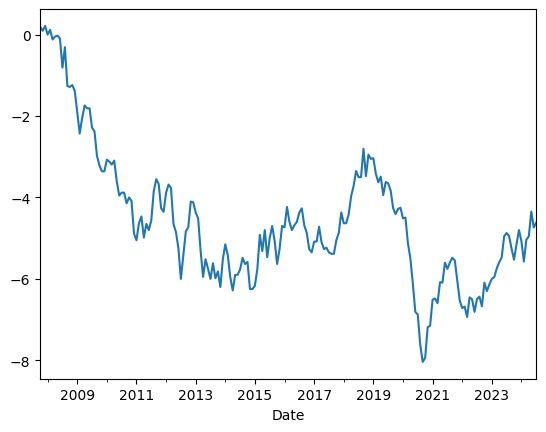

In [382]:
m5_ic.sort_index().cumsum().plot()

sub(PPI industry data for Aircraft engine and engine parts mfg, neg(ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems
))
fitness: 0.8747878787878788, depth: 2, length: 4


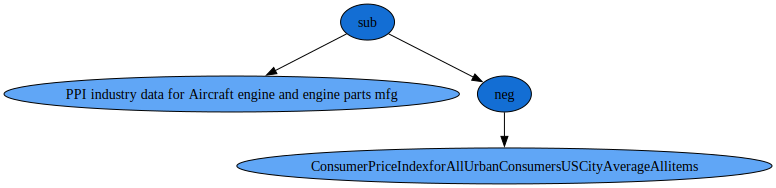

In [383]:
alpha_factor_graph(16)

In [384]:
def macro_factor_16(df):
    value1 = - df['ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n']
    value = df['PPI industry data for Aircraft engine and engine parts mfg'] - value1
    
    return value.unstack('Tickers')

       name  IC mean  IC std      IR    IC>0  ABS_IC>2%  t_stat
0  macro_16   0.0975  0.4148  0.2351  0.5644     0.9703  3.3414


<Axes: xlabel='Date'>

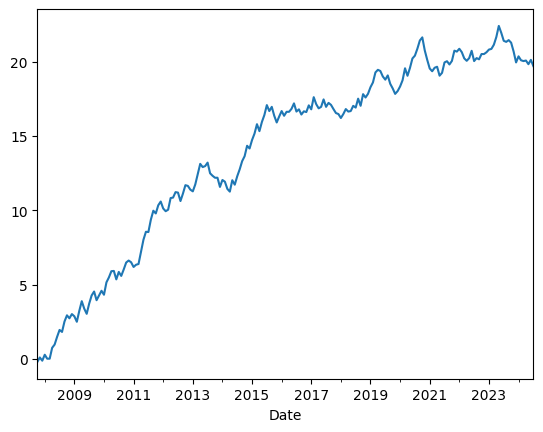

In [386]:
macro_16 = macro_factor_16(rolling_exposure)
m16_ic, m16_df = Rank_IC(macro_16, returns, 'macro_16')
m16_ic.sort_index().cumsum().plot()